# Прогнозирование уровня средней заработной платы в России 

In [1]:
# импортируем необходимые библиотеки
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

# функция для обратного преобразования из Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
salary = pd.read_csv('WAG_C_M.csv', sep = ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


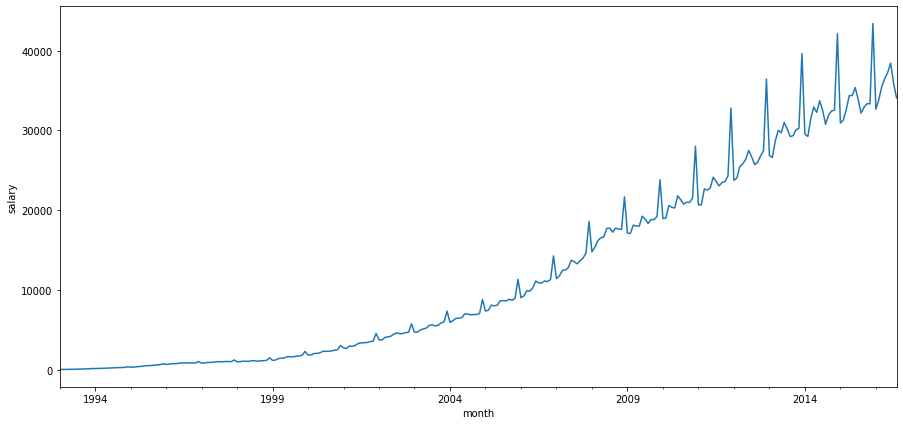

In [3]:
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
plt.ylabel('salary')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

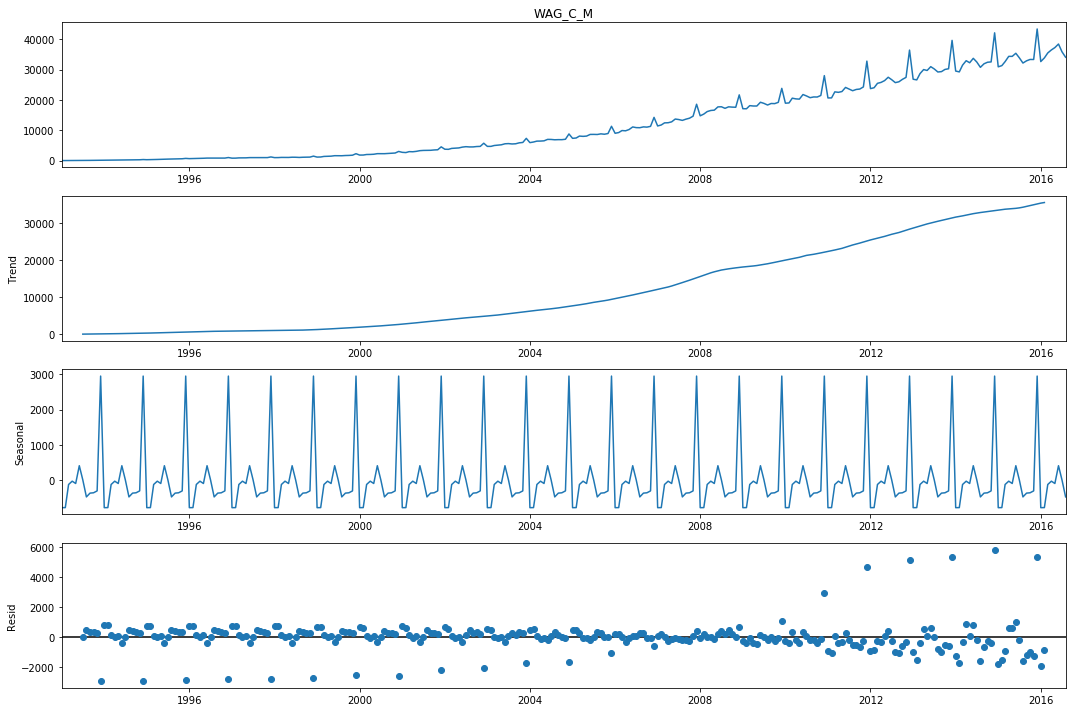

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

Основываясь на графиках можно сделать выводы
- прослеживается явный восходящий тренд
- присутствует сезонность
- отсутствует стационарность
- необходимо стабилизировать дисперсию
- критерий Дики-Фуллера уверенно не отвергает гипотезу нестационарности

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


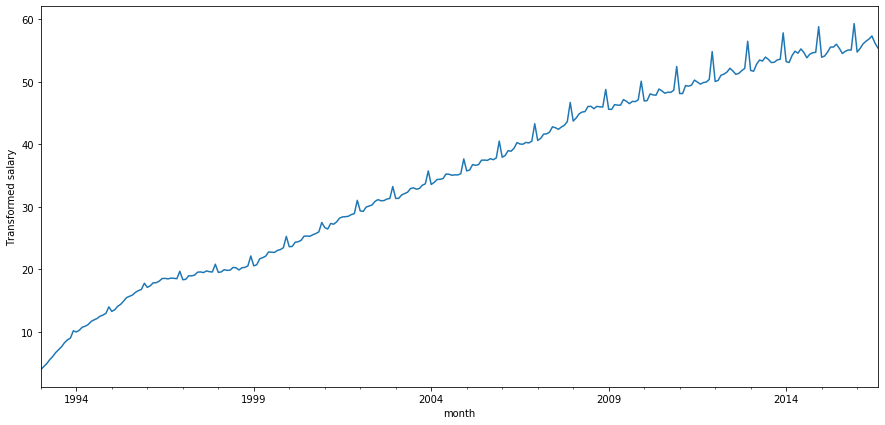

In [5]:
salary['salary_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15,7))
salary.salary_box.plot()
plt.ylabel('Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

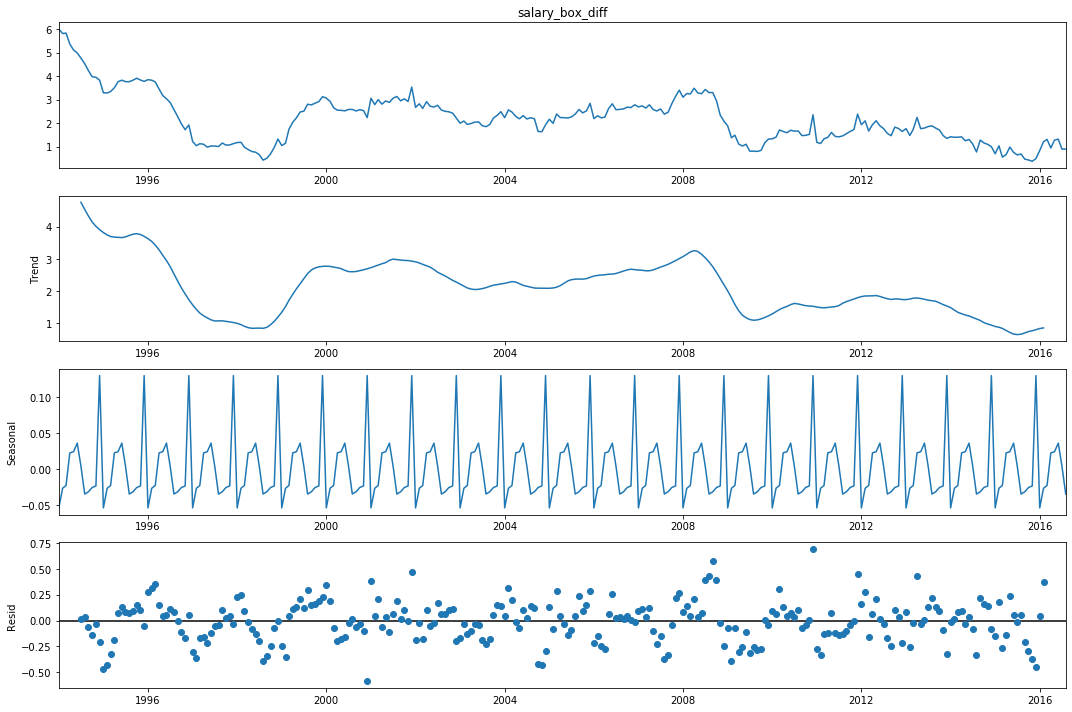

In [6]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально прослеживается теперь нисходящий тренд. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

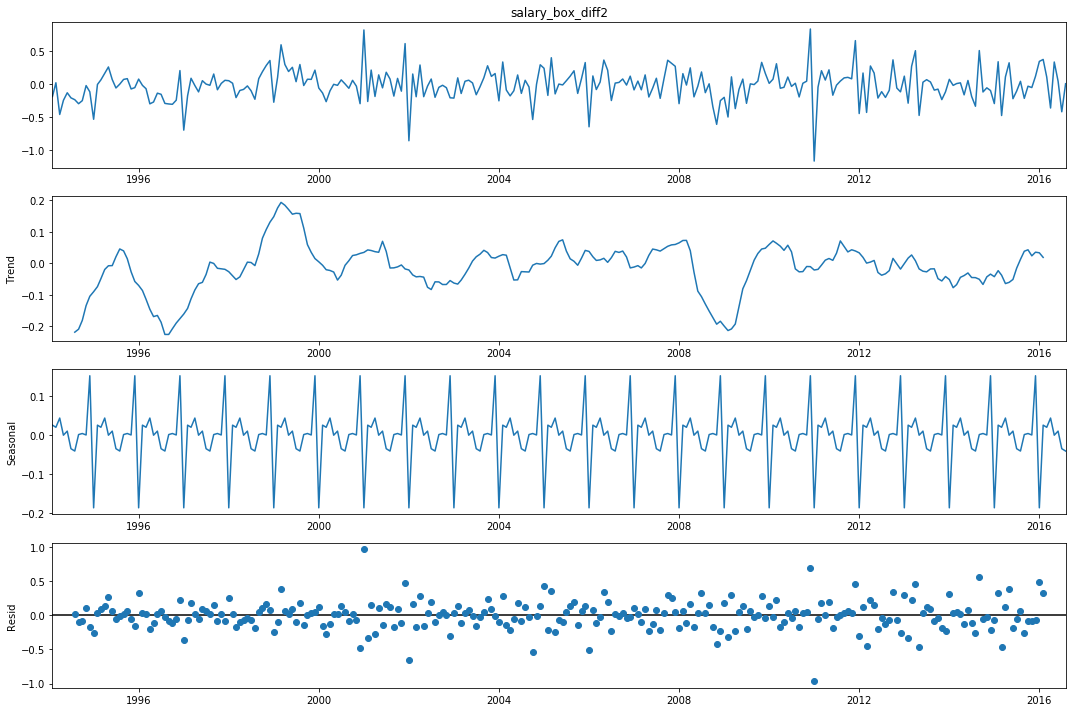

In [7]:
salary['salary_box_diff2'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff2[13:])[1])

Гипотеза нестационарности уверенно отвергается, и визуально ряд выглядит лучше.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

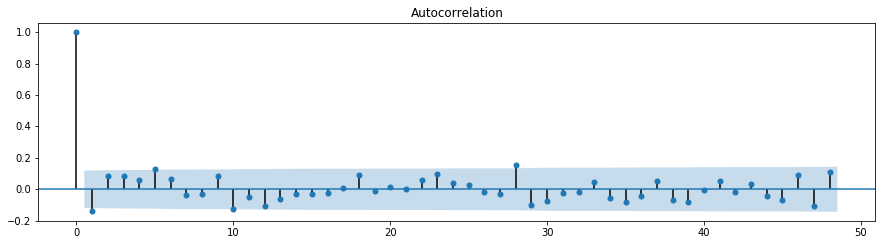

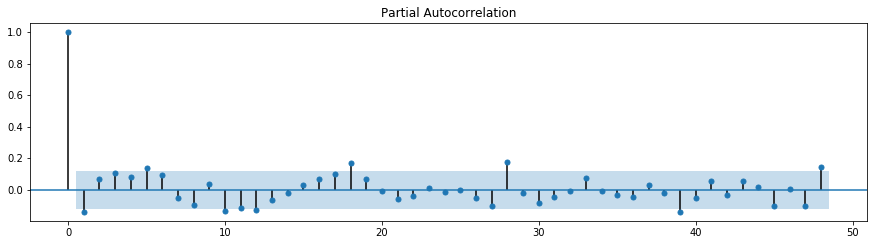

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Если основываться на данные графиков, то можно выбрать начальные приближения начальные приближения: Q = 0, q = 1, P = 4, p = 1

Составим всевозможные комбинации гиперпараметром Q, q, P, p

In [10]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

20

Отберем по критерию Акаике лучшую модель

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 13.9 s


In [13]:
# выведем 5 наилучших параметров
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
11  (1, 0, 1, 0)  0.340521
6   (0, 1, 1, 0)  1.170768
12  (1, 0, 2, 0)  1.622924
16  (1, 1, 1, 0)  2.021911
7   (0, 1, 2, 0)  2.509650


Лучшая модель:

In [14]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Wed, 17 Jun 2020   AIC                              0.341
Time:                                    18:53:05   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Её остатки:

Критерий Стьюдента: p=0.090792
Критерий Дики-Фуллера: p=0.000003


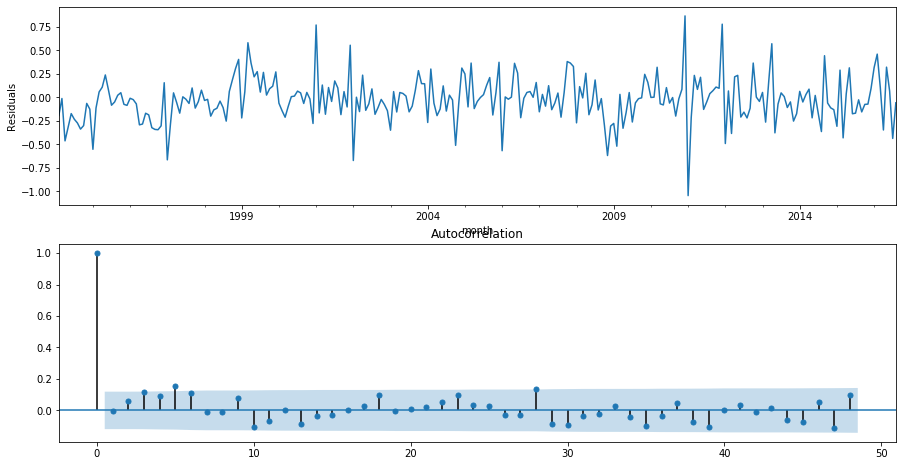

In [15]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

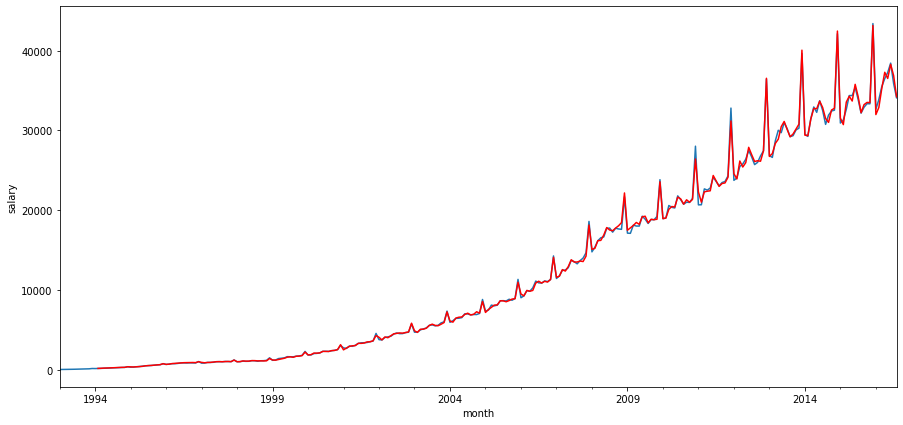

In [16]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('salary')
pylab.show()

Визуально наша модель достаточно неплохо описывает имеющиеся данные

### Прогноз

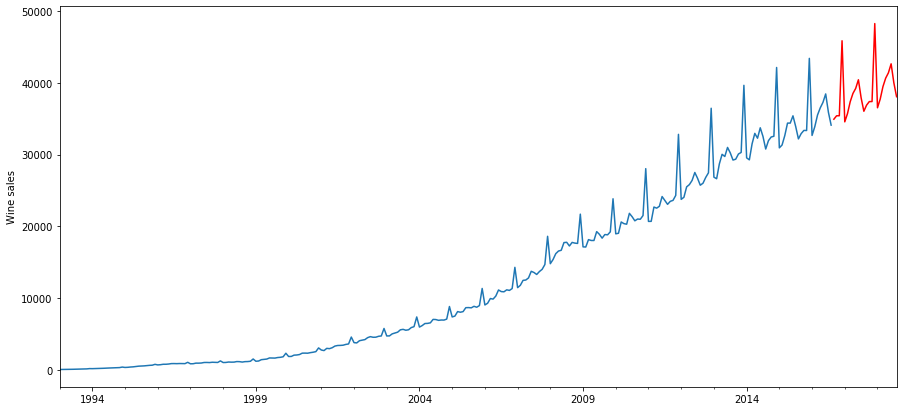

In [17]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

### Тестирование модели
Имеются данные 2016 - 2018 годы(которые мы не использовали при обучении модели) и сравним насколько они совпадают с нашим прогнозом

In [18]:
# Импорт известных на данный момент значений средней зарплаты с 2016 по 2018 год для проверки модели:
df1 = pd.DataFrame([['01.09.2016',35843.0],['01.10.2016',35749.0],['01.11.2016',36195.0],['01.12.2016',47554.0],['01.01.2017',34422.0],['01.02.2017',35497.0],['01.03.2017',37899.0],['01.04.2017',39225.0],['01.05.2017',39679.0],['01.06.2017',41454.0],['01.07.2017',38073.0],['01.08.2017',37099.0],['01.09.2017',38047.0],['01.10.2017',38333.0],['01.11.2017',38848.0],['01.12.2017',51197.0],['01.01.2018',39017.0],['01.02.2018',40443.0],['01.03.2018',42364.0],['01.04.2018',43381.0],['01.05.2018',44076.0],['01.06.2018',45848.0],['01.07.2018',42413.0],['01.08.2018',41364.0],['01.09.2018',41774.0],['01.10.2018',42000.0]], columns = ('month', 'WAG_C_M'))
df1 = pd.DataFrame(df1.WAG_C_M.values, index = pd.to_datetime(df1.month, dayfirst = True), columns = ['WAG_C_M'])

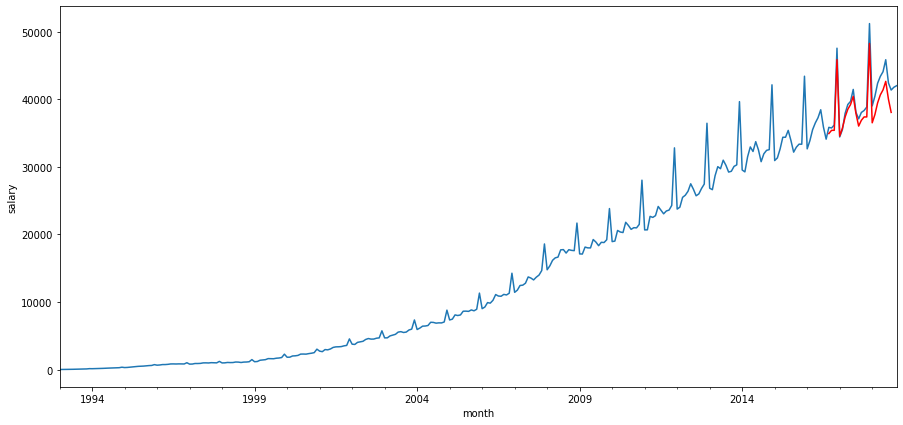

In [19]:
salary3 = salary[['WAG_C_M']]
salary3 = pd.concat([salary3, df1])
salary3['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
salary3.WAG_C_M.plot()
salary3.forecast.plot(color='r')
plt.ylabel('salary')
pylab.show()